In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Install Dependencies

In [ ]:
!pip3 install flair
!pip install contractions
!pip install beautifulsoup4
!pip install twython
!pip install pyspark
!pip install -U -q PyDrive
!pip install tld
!apt install openjdk-8-jdk-headless -qq

# Imports

In [2]:
import pandas as pd
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
# import flair

import pyspark.pandas as ps
import os
from ast import literal_eval
import bz2
import json
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
from tld import get_tld

os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
nltk.download('stopwords')
nltk.download('vader_lexicon')

from nltk.corpus import stopwords
import contractions
from bs4 import BeautifulSoup
import unicodedata
import re
import numpy as np

REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))
from nltk.stem.porter import *
stemmer = PorterStemmer()
#print(STOPWORDS)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


# 1. Sentiment Analysis

## 1.1 Create data sample

In [4]:
path_to_file = '/content/drive/MyDrive/Quotebank/quotes-2020.json.bz2' 

c=0

appended_data = []
max_v=500000
with bz2.open(path_to_file, 'rb') as s_file:
    # with bz2.open(path_to_out, 'wb') as d_file:
        for instance in s_file:
            c+=1
            instance = json.loads(instance) # loading a sample
            df = pd.json_normalize(instance)
            df = df.drop(['speaker','qids','date','numOccurrences','probas','urls','phase'], axis=1)
            appended_data.append(df)
            # print(instance)
            if c%100000==0:
              print(c)
            if c==max_v:
                break

appended_data = pd.concat(appended_data)
# quotes = appended_data.drop(['speaker','qids','date','numOccurrences','probas','urls','phase'], axis=1)
appended_data.describe()

quoteID                                          quotation
count               50000                                              50000
unique              50000                                              50000
top     2020-04-08-042587  It's a tight contest. We won't know the final ...
freq                    1                                                  1

In [6]:
appended_data.reset_index(drop=True, inplace=True)
# appended_data.drop(["index"], axis=1, inplace=True)
appended_data.head()

quoteID                                          quotation
0  2020-01-28-000082  [ D ] espite the efforts of the partners to cr...
1  2020-01-16-000088  [ Department of Homeland Security ] was livid ...
2  2020-02-10-000142  ... He (Madhav) also disclosed that the illega...
3  2020-02-15-000053                  ... [ I ] f it gets to the floor,
4  2020-01-24-000168  [ I met them ] when they just turned 4 and 7. ...

## 1.2 Text Preprocessing

In [ ]:
def strip_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    [s.extract() for s in soup(['iframe', 'script'])]
    stripped_text = soup.get_text()
    stripped_text = re.sub(r'[\r|\n|\r\n]+', '\n', stripped_text)
    return stripped_text

def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text

def expand_contractions(text):
    return contractions.fix(text)

def remove_special_characters(text, remove_digits=False):
    pattern = r'[^a-zA-Z0-9\s]' if not remove_digits else r'[^a-zA-Z\s]'
    text = re.sub(pattern, '', text)
    return text

def pre_process_document(document):
    # print(document)
    
    st=re.search(r'\[([^]]+)\]', document)
    if(st):
      st=st.group(1)
      document = document.replace(st,"")
    
    document = ' '.join(word for word in document.split() )#if word.lower() not in STOPWORDS) 
    # document = st+document[]
    document = REPLACE_BY_SPACE_RE.sub(' ', document) 
    # lower case
    document = document.lower()
    # remove links
    
    # remove extra newlines (often might be present in really noisy text)
    document = document.translate(document.maketrans("\n\t\r", "   "))
    # remove special characters
    document = remove_special_characters(document, remove_digits=False)  
    # remove extra whitespace
    document = re.sub(' +', ' ', document)
    
    document = document.strip()
    if(st):
      sb=st.lower().strip()
      if(len(sb)>1):
        sb+=" "
      document = sb + document
    
    # document = ' '.join(word for word in document.split() if word.lower() not in STOPWORDS) 
  
    return document


# 1.3 Saving/Loading sample data

In [ ]:
# out='/content/drive/MyDrive/ADA/quotes_sample.csv'
# appended_data.to_csv(out,index=False)
appended_data=pd.read_csv('/content/drive/MyDrive/ADA/quotes_sample.csv')
appended_data.head()

quoteID                                          quotation
0  2020-01-28-000082  [ D ] espite the efforts of the partners to cr...
1  2020-01-16-000088  [ Department of Homeland Security ] was livid ...
2  2020-02-10-000142  ... He (Madhav) also disclosed that the illega...
3  2020-02-15-000053                  ... [ I ] f it gets to the floor,
4  2020-01-24-000168  [ I met them ] when they just turned 4 and 7. ...

In [ ]:
dataset=appended_data.copy()
dataset['quotation'] = dataset['quotation'].apply(pre_process_document)
dataset.head()

quoteID                                          quotation
0  2020-01-28-000082  despite the efforts of the partners to create ...
1  2020-01-16-000088  department of homeland security was livid and ...
2  2020-02-10-000142  he madhav also disclosed that the illegal brib...
3  2020-02-15-000053                            if it gets to the floor
4  2020-01-24-000168  i met them when they just turned 4 and 7 they ...

In [ ]:
# out='/content/drive/MyDrive/ADA/quotes_sample_preprocessed2.csv'
# dataset.to_csv(out,index=False)

# 1.4 Loading Dataset

In [ ]:
dataset=pd.read_csv('/content/drive/MyDrive/ADA/quotes_sample_preprocessed2.csv')
dataset.head()

quoteID                                          quotation
0  2020-01-28-000082  despite the efforts of the partners to create ...
1  2020-01-16-000088  department of homeland security was livid and ...
2  2020-02-10-000142  he madhav also disclosed that the illegal brib...
3  2020-02-15-000053                            if it gets to the floor
4  2020-01-24-000168  i met them when they just turned 4 and 7 they ...

In [ ]:
dataset.dropna(axis=0, inplace=True)

In [ ]:
sample=dataset.sample(n=100,random_state=0)
sample.reset_index(inplace=True,drop=True)
print(sample.head())

             quoteID                                          quotation
0  2020-03-11-052346              so he decided he just had to tell you
1  2020-01-01-016038  if you do what we tell you to do you will go t...
2  2020-04-03-081020            with great power comes great narcissism
3  2020-01-13-097344  yusaku maezawas serious matchmaking documentar...
4  2020-02-05-019027  even when lee doesnt score she handles the bal...


# 1.4 Sentiment prediction

In [ ]:
flair_sentiment = flair.models.TextClassifier.load('en-sentiment')
nltk_sentiment = SentimentIntensityAnalyzer()

In [ ]:
#Comparison of sentiments provided by flair and nltk analyzer
# NLTK
sent=dataset.iloc[12]['quotation']
print(sent)
print()
print("NLTK: ",nltk_sentiment.polarity_scores(sent))
#Flair
s = flair.data.Sentence(sent)
flair_sentiment.predict(s)
total_sentiment = s.labels
print("Flair: ",total_sentiment)

we deserve a president like him

{'neg': 0.0, 'neu': 0.615, 'pos': 0.385, 'compound': 0.3612}
[POSITIVE (0.8976)]


In [ ]:
nltk_sentiment = SentimentIntensityAnalyzer()

def classify_sentiment(doc):

   scores = nltk_sentiment.polarity_scores(doc)
   neg_sc=scores['neg']	
   neu_sc=scores['neu']
   pos_sc=scores['pos']
   compound_sc=scores['compound']
   sentiment=np.argmax(np.array([neg_sc,neu_sc,pos_sc,compound_sc]))
   scores['sentiment'] = sentiment
   return scores


applied_df = dataset.apply(lambda row: classify_sentiment(row.quotation), axis='columns', result_type='expand')
applied_df.head()

neg    neu    pos  compound  sentiment
0  0.000  0.768  0.232    0.8720        3.0
1  0.184  0.579  0.237    0.0000        1.0
2  0.116  0.837  0.047   -0.4939        1.0
3  0.000  1.000  0.000    0.0000        1.0
4  0.000  0.870  0.130    0.3041        1.0

In [ ]:
np.unique(applied_df['sentiment'], return_counts=True)

(array([0., 1., 2., 3.]), array([  4495, 417374,   1947,  76177]))

In [ ]:
print(dataset.shape,applied_df.shape)
df = pd.concat([dataset, applied_df],axis='columns')
df.head()

(499993, 2) (499993, 5)


quoteID  ... sentiment
0  2020-01-28-000082  ...       3.0
1  2020-01-16-000088  ...       1.0
2  2020-02-10-000142  ...       1.0
3  2020-02-15-000053  ...       1.0
4  2020-01-24-000168  ...       1.0

[5 rows x 7 columns]

In [ ]:
out='/content/drive/MyDrive/ADA/quotes_sentiments.csv'
df.to_csv(out,index=False)

In [ ]:
rev_label=['negative','neutral','positive','compound']
temp = df[['quotation','sentiment']]
temp.head()
print(temp.shape)

(499993, 2)


In [ ]:
rev_label=['negative','neutral','positive','compound']
temp['sentiment'] = temp['sentiment'].map(lambda row: rev_label[int(row)])

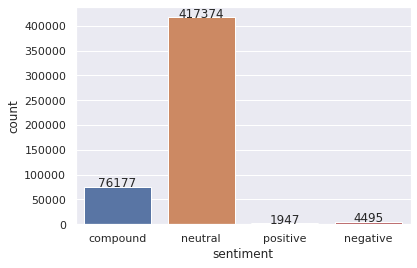

In [ ]:
sns.set(style="darkgrid")
ax = sns.countplot(x='sentiment', data=temp)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2., height + 0.1,height ,ha="center")

# Wordcloud representation of most occuring words in each sentiment class 

Neutral Words


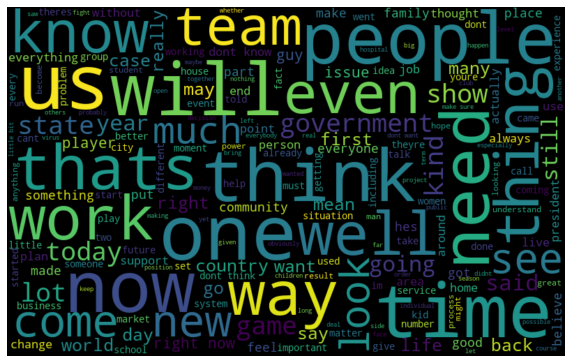

Negative Words


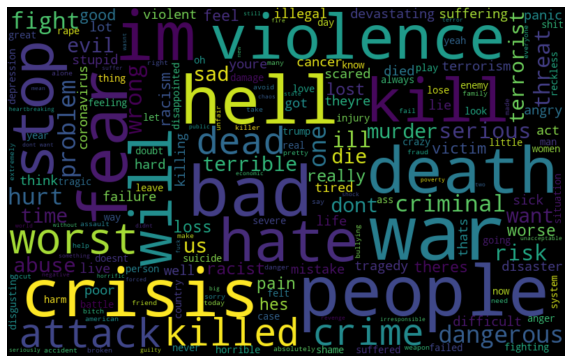

Positive Words


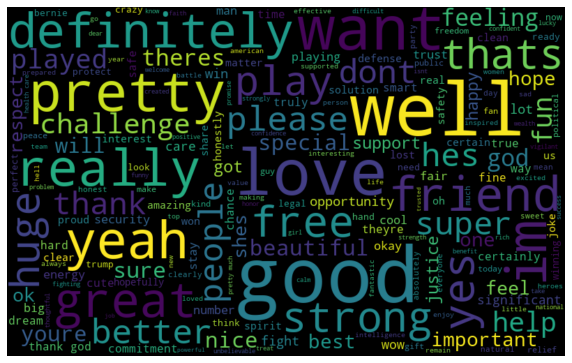

Compound Words


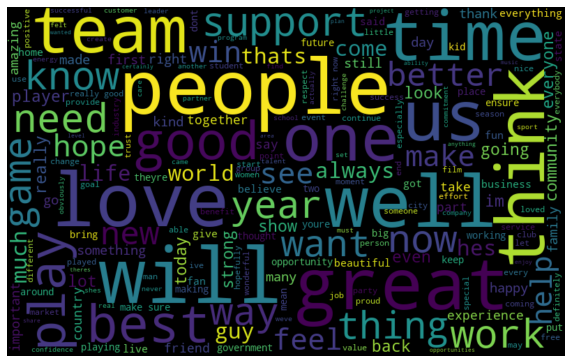

In [ ]:
print("Neutral Words")

neu_words =' '.join([text for text in df['quotation'][df['sentiment'] == 1]])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(neu_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

print("Negative Words")

neg_words =' '.join([text for text in df['quotation'][df['sentiment'] == 0]])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(neg_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

print("Positive Words")

pos_words =' '.join([text for text in df['quotation'][df['sentiment'] == 2]])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(pos_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

print("Compound Words")

compound_words =' '.join([text for text in df['quotation'][df['sentiment'] == 3]])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(compound_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()


In [ ]:
sentiment_data=pd.read_csv('/content/drive/MyDrive/ADA/quotes_sentiments.csv')

In [ ]:
sentiment_data

quoteID  ... sentiment
0       2020-01-28-000082  ...       3.0
1       2020-01-16-000088  ...       1.0
2       2020-02-10-000142  ...       1.0
3       2020-02-15-000053  ...       1.0
4       2020-01-24-000168  ...       1.0
...                   ...  ...       ...
499988  2020-04-15-004470  ...       1.0
499989  2020-02-21-005024  ...       1.0
499990  2020-01-30-007507  ...       1.0
499991  2020-01-30-007577  ...       1.0
499992  2020-04-02-004931  ...       1.0

[499993 rows x 7 columns]

In [ ]:
#appended_data.to_csv('/content/drive/MyDrive/ADA/quotes_500k.csv',index=False)
appended_data=pd.read_csv('/content/drive/MyDrive/ADA/quotes_500k.csv')

In [ ]:
temp = pd.merge(sentiment_data, appended_data, on='quoteID', how='left')
t1 = temp.drop(['quotation_y','probas','urls','phase','neg', 'neu',	'pos', 'compound'], axis = 1)
t2 = t1.rename({'quotation_x': 'quotation'}, axis=1)
t2.head()

quoteID  ... numOccurrences
0  2020-01-28-000082  ...              1
1  2020-01-16-000088  ...              1
2  2020-02-10-000142  ...              1
3  2020-02-15-000053  ...              2
4  2020-01-24-000168  ...              4

[5 rows x 7 columns]

In [ ]:
rev_label=['negative','neutral','positive','compound']
t2['sentiment'] = t2['sentiment'].map(lambda row: rev_label[int(row)])
t2.head()

quoteID  ... numOccurrences
0  2020-01-28-000082  ...              1
1  2020-01-16-000088  ...              1
2  2020-02-10-000142  ...              1
3  2020-02-15-000053  ...              2
4  2020-01-24-000168  ...              4

[5 rows x 7 columns]

In [ ]:
# print(t2.shape)
t2=t2[t2['qids'].map(lambda d: len(d)) > 0]
# print(t2.shape)
t3 = t2.drop(['qids'], axis = 1)
t3.head()

(327972, 7)
(327972, 7)


quoteID  ... numOccurrences
1  2020-01-16-000088  ...              1
4  2020-01-24-000168  ...              4
7  2020-01-17-000357  ...              1
8  2020-04-02-000239  ...              1
9  2020-03-19-000276  ...              1

[5 rows x 6 columns]

In [ ]:
t3.to_csv('/content/drive/MyDrive/ADA/sample_with_sentiment_and_speaker.csv',index=False)

# 2. News Topics

## 2.1 Reading Data

In [4]:
path_to_file = '/content/drive/MyDrive/ADA/quotes-2019-nytimes.json.bz2' 
#path_to_out = '/content/quotes-2020-domains.json.bz2'
domains = []
speakers = []
quotation = []
popularity = []

with bz2.open(path_to_file, 'rb') as s_file:
        for instance in s_file:
            instance = json.loads(instance) # loading a sample
            urls = instance['urls'] # extracting list of links
            popularity.append(len(instance['urls']) - 1)
            domains.append(instance['urls'])
            quotation.append(instance['quotation'])
            speakers.append(instance['speaker'])
            
            

## 2.2 Extract NYT Links from the domain

In [5]:
from urllib.parse import * 
parse_url = urlparse(domains[1][0])
nyt_urls = []
non_nyt = []

for domain in domains:
  count = 0
  for url in domain:
    parsed_url = urlparse(url)
    if parsed_url.netloc == 'www.nytimes.com' or parsed_url.netloc == 'nytimes.com' or parsed_url.netloc == 'mobile.nytimes.com' or parsed_url.netloc == 'feeds.nytimes.com':
      nyt_urls.append(parsed_url)
      count = 1  
      break 
  if count == 0:
    nyt_urls.append(urlparse('https://www.nytimes.com/unknown'))
    non_nyt.append(domain)

## 2.3 Extracting Topics from NYT Links and Preliminary Analysis

In [6]:
topics = []
for url in nyt_urls:
  count = 0
  start = 12
  if url.path[1:] == 'unknown':
    topics.append('unknown')
    continue  
  if url.netloc == 'feeds.nytimes.com':
    start = 24
  if url.path[1:12] == 'interactive':
    start = 24
  if url.path[1:5] == 'live':
    topics.append('live')
    continue  
  
  for letter in url.path[start:]:
    if letter == '/':
      break
    count = count+ 1
  topics.append(url.path[start:][:count])

Create Pandas DataFrame. Contains Topic, Speaker, Quotation which are defined above and popularity which is the number of news outlets that have shared the news item

In [7]:
data = pd.DataFrame(topics, columns =['topic'])
data['speaker'] = speakers
data['quotation'] = quotation
data['popularity'] = popularity
data.head()

topic  ... popularity
0  realestate  ...          0
1     opinion  ...          1
2       world  ...          0
3  technology  ...          2
4       books  ...          0

[5 rows x 4 columns]

Plot the counts of the most popular topics published by NYT

In [8]:
top10 = data.groupby('topic').count()['speaker'].sort_values(ascending=False)[:10]

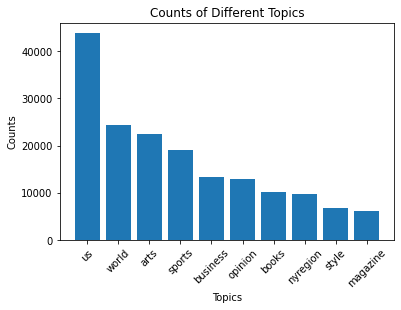

In [9]:
plt.xticks(rotation=45)
plt.bar(list(top10.index), top10.values)
plt.title('Counts of Different Topics')
plt.ylabel('Counts')
plt.xlabel('Topics')
plt.show()

Print the most popular speakers for different topics 

In [10]:
data_filtered = data[data.speaker != 'None']
famous_speaker = data_filtered.groupby(['topic', 'speaker']).count()['popularity']

In [11]:
print("Most Popular Speakers wrt different topics")
famous_speaker.sort_values(ascending=False)[:20]

Most Popular Speakers wrt different topics


topic     speaker               
us        President Donald Trump    1317
          President Trump           1086
          Joe Biden                  611
          Elizabeth Warren           583
          Bernie Sanders             426
          Nancy Pelosi               408
          Pete Buttigieg             397
world     President Donald Trump     288
nyregion  Bill de Blasio             271
opinion   President Donald Trump     265
arts      Stephen Colbert            256
us        Cory Booker                251
world     Mike Pompeo                232
opinion   President Trump            232
world     President Trump            209
us        Amy Klobuchar              204
          Mitch McConnell            201
arts      JIMMY KIMMEL               199
business  President Trump            196
arts      STEPHEN COLBERT            189
Name: popularity, dtype: int64

Plot the popularity of the major topics. Popularity is the average number of news outlets that share a particular news item

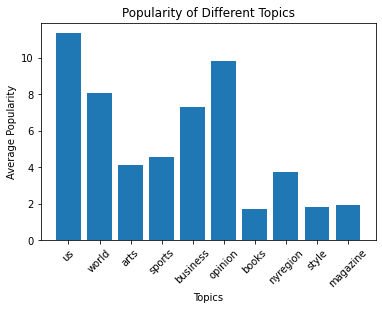

In [12]:
popularity_top10 = data.groupby('topic').mean()['popularity'][top10.index]
plt.xticks(rotation=45)
plt.bar(list(popularity_top10.index), popularity_top10.values)
plt.title('Popularity of Different Topics')
plt.ylabel('Average Popularity')
plt.xlabel('Topics')
plt.show()

# 3. News Vendor Analysis

## Url Extraction

In [ ]:
# import bz2, shutil
# with bz2.BZ2File('/content/drive/MyDrive/Quotebank/quotes-2020-domains.json.bz2') as inp:
#         with open('/content/drive/MyDrive/ADA/quotes-2020-domains.json', 'w') as out:
#             shutil.copyfileobj(inp, out)

In [19]:
"the path file is decompressed from quotes-2020-domains.json.bz2, and we use data to read the file"
path = '/content/drive/MyDrive/ADA/quotes-2020-domains.json'
c=0
maxv=50000

data = []
for line in open(path, 'r'):
    c+=1
    data.append(json.loads(line))
    if c==maxv:
      break
print(len(data))
"This code is used to extract the information from the urls can get the main imformation of urls"
# http:// + main information + / + details -> main information
urls = []
for i in range(len(data)):
    urls.append(data[i]["urls"])
    
url1 = []
for i in range(len(urls)):   
    url1.append(urls[i][0][urls[i][0].index("//"):])

url2 = []
for i in range(len(url1)):   
    url2.append(url1[i][2:])

url_sample = []
for i in range(len(url2)):   
    try:
        url_sample.append(url2[i][:url2[i].index('/')])
    except:
        continue
#         print(i) # print the index of urls where not have a "/" after the main information

50000


In [21]:
url_sample1 = url_sample
url_sample_distinct = list(set(url_sample1)) 
count = []

for i in url_sample_distinct:
    t = url_sample1.count(i)
    count.append(t)

In [22]:
df = pd.DataFrame(columns=['urls', 'counts'])
df['urls'] = url_sample_distinct
df['counts'] = count
df = df.sort_values(by = 'counts', ascending=False)
df.reset_index(inplace=True)
df

index                          urls  counts
0      1821             www.breitbart.com     414
1      1235                   www.msn.com     364
2      2851                       msn.com     293
3      1606                 express.co.uk     286
4      4448          www.seattletimes.com     245
...     ...                           ...     ...
5334    579           allindiaroundup.com       1
5335    243      www.whatinvestment.co.uk       1
5336    578             www.waynepost.com       1
5337   4125  www.stthomastimesjournal.com       1
5338   5338          www.caranddriver.com       1

[5339 rows x 3 columns]

In [23]:
df_sample = df[:10]

Text(0.5, 1.0, 'The number of appearances for top 10 News Vendors')

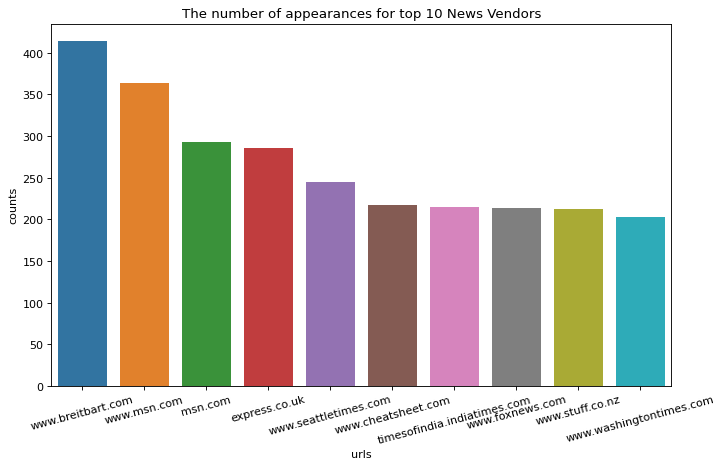

In [24]:
plt.figure(figsize=(10, 6), dpi=80)
ax = sns.barplot(x="urls", y="counts", data=df_sample)
plt.xticks(rotation='15')
plt.title("The number of appearances for top 10 News Vendors")

Text(0.5, 1.0, 'The distribution of times appear for different News Vendors')

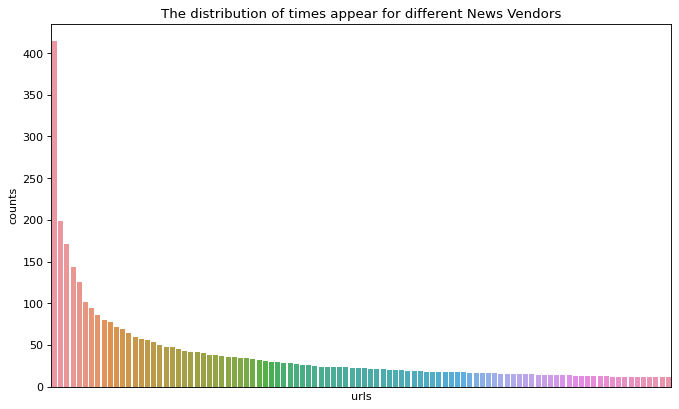

In [25]:
# plt.figure(figsize=(10, 6), dpi=80)
# ax = sns.barplot(x="urls", y="counts", data=df[:1000:10])
# plt.xticks([])
# plt.title("The distribution of times appear for different News Vendors")

# 4. Speaker Analysis

## 4.1 Extracting Top speakers using counts

In [26]:
person = []
for i in range(len(data)):
    person.append(data[i]["speaker"])
person = person[:100000]
person_distinct = list(set(person)) 
counts = []

for i in person_distinct:
    t = url_sample1.count(i)
    counts.append(t)

df1 = pd.DataFrame(columns=['person', 'counts'])
df1['person'] = person_distinct
df1['counts'] = counts

df1 = df1.sort_values(by = 'counts', ascending=False)
df1.reset_index(inplace=True)
df1[:8]

index          person  counts
0      0         Tan Kai       0
1  13647      Yemi Alade       0
2  13705   Dan Zwonitzer       0
3  13704   Billy Gibbons       0
4  13703   Brandon Gomes       0
5  13702   Ken Dychtwald       0
6  13701  Richard Devlin       0
7  13700    Eric Tinkler       0

## 4.2 Comparison of News vendors' coverage of 2 presidential candidates

In [27]:
person_urls = []
for i in range(len(data)):
    person_urls.append(data[i]["speaker"])
    person_urls.append(data[i]["urls"])

### First, we collect the URLs conected to trump

In [28]:
trump_urls = []
for i in range(int(len(person_urls)/2)):
    if person_urls[2*i] == 'President Donald Trump':
        trump_urls.append(person_urls[2*i+1])
    if person_urls[2*i] == 'President Trump':
        trump_urls.append(person_urls[2*i+1])

trump_url1=[]
for i in range(len(trump_urls)):   
    trump_url1.append(trump_urls[i][0][trump_urls[i][0].index("//"):])

trump_url2 = []
for i in range(len(trump_url1)):   
    trump_url2.append(trump_url1[i][2:])

trump_url_sample = []
for i in range(len(trump_url2)):   
    try:
        trump_url_sample.append(trump_url2[i][:trump_url2[i].index('/')])
    except:
        continue
        # print(i) # print the index of urls where not have a "/" after the main information
        
trump_url_distinct = list(set(trump_url_sample)) 
trump_counts = []

for i in trump_url_distinct:
    t = trump_url_sample.count(i)
    trump_counts.append(t)
    
trump_df = pd.DataFrame(columns=['urls', 'counts'])
trump_df['urls'] = trump_url_distinct
trump_df['counts'] = trump_counts
trump_df = trump_df.sort_values(by = 'counts', ascending=False)
trump_df.reset_index(inplace=True)

trump = trump_df['urls'][:10]

### Then, we collect the urls conected to Biden

In [29]:
biden_urls = []
for i in range(int(len(person_urls)/2)):
    if person_urls[2*i] == 'Joe Biden':
        biden_urls.append(person_urls[2*i+1])

biden_url1=[]
for i in range(len(biden_urls)):   
    biden_url1.append(biden_urls[i][0][biden_urls[i][0].index("//"):])

biden_url2 = []
for i in range(len(biden_url1)):   
    biden_url2.append(biden_url1[i][2:])

biden_url_sample = []
for i in range(len(biden_url2)):   
    try:
        biden_url_sample.append(biden_url2[i][:biden_url2[i].index('/')])
    except:
        continue
        # print(i) # print the index of urls where not have a "/" after the main information

biden_url_distinct = list(set(biden_url_sample)) 
biden_counts = []

for i in biden_url_distinct:
    t = biden_url_sample.count(i)
    biden_counts.append(t)

biden_df = pd.DataFrame(columns=['urls', 'counts'])
biden_df['urls'] = biden_url_distinct
biden_df['counts'] = biden_counts
biden_df = biden_df.sort_values(by = 'counts', ascending=False)
biden_df.reset_index(inplace=True)

biden = biden_df['urls'][:10]

In [30]:
trump_df[:10]

index               urls  counts
0    170        thehill.com      10
1    252  www.breitbart.com      10
2    213        www.msn.com       9
3    230  feeds.foxnews.com       8
4    121        cnsnews.com       7
5    164   www.rawstory.com       6
6    101    www.nbcnews.com       5
7    128        www.vox.com       5
8     30    www.foxnews.com       5
9    192    www.nytimes.com       5

In [31]:
biden_df[:10]

index                        urls  counts
0     76           feeds.foxnews.com       5
1     70                 www.msn.com       5
2      4      uspolitics.einnews.com       4
3     44  www.washingtonexaminer.com       4
4     42         europe.newsweek.com       4
5     86           www.breitbart.com       4
6     14             www.foxnews.com       3
7     84         www.bostonglobe.com       3
8     11            www.politico.com       3
9     32             www.nbcnews.com       3

### We plot number of times the person has appeared for selected urls

In [ ]:
# www.breitbart.com
# www.msn.com
# feeds.foxnews.com
# thehill.com
# uspolitics.einnews.com
# www.foxnews.com
# www.breitbart.com
# www.nbcnews.com
x = ['www.breitbart.com','www.msn.com','feeds.foxnews.com','thehill.com','uspolitics.einnews.com','hypervocal.com']
y1 = []
for i in x:
    # print(i)
    y1.append(int(trump_df[trump_df['urls']==i]['counts']))

y2 = []
for i in x:
    # print(i)
    y2.append(int(biden_df[biden_df['urls']==i]['counts']))
    
plt.plot(x,y1,label='Trump')
plt.plot(x,y2,label='Biden')
plt.xticks(rotation='15')
plt.legend()
print()

# Speaker Attributes Dataset

In [42]:
par = pd.read_parquet('/content/drive/MyDrive/ADA/speaker_attributes.parquet', engine='pyarrow')

In [43]:
wikidata = pd.read_csv('/content/drive/MyDrive/ADA/wikidata_labels_descriptions_quotebank.csv.bz2', compression='bz2', index_col='QID')

### Parse attributes ([QID] -> [values])

In [ ]:
f = lambda x: x[0]
gend = par['gender'].fillna('inc').values
res = wikidata.loc[np.array([f(x) for x in gend])]['Label'].values
par['gender_parse'] = res

In [ ]:
g = lambda x: [wikidata.loc[x[i]]['Label'] for i in range(len(x))]
nationality = par['nationality'].dropna()
nationality_parse = nationality.apply(g)
nat_parse = par['nationality'].copy()
nat_parse[par['nationality'].notnull()] = nationality_parse.copy()
par['nationality_parse'] = nat_parse.copy()

In [ ]:
religion = par['religion'].dropna()
religion_parse = religion.apply(g)
rel_parse = par['religion'].copy()
rel_parse[par['religion'].notnull()] = religion_parse.copy()
par['religion_parse'] = rel_parse.copy()

In [ ]:
candidacy = par['candidacy'].dropna()
candidacy_parse = candidacy.apply(g)
cand_parse = par['candidacy'].copy()
cand_parse[par['candidacy'].notnull()] = candidacy_parse.copy()
par['candidacy_parse'] = cand_parse.copy()

In [ ]:
ethnic_group = par['ethnic_group'].dropna()
ethnic_group_parse = ethnic_group.apply(g)
eth_parse = par['ethnic_group'].copy()
eth_parse[par['ethnic_group'].notnull()] = ethnic_group_parse.copy()
par['ethnic_group_parse'] = eth_parse.copy()

In [ ]:
g = lambda x: [wikidata.loc[x[i]]['Label'] if x[i] in wikidata.index else None for i in range(len(x))]
occupation = par['occupation'].dropna()
occupation_parse = occupation.apply(g)
occ_parse = par['occupation'].copy()
occ_parse[par['occupation'].notnull()] = occupation_parse.copy()
par['occupation_parse'] = occ_parse.copy()

In [ ]:
party = par['party'].dropna()
party_parse = party.apply(g)
part_parse = par['party'].copy()
part_parse[par['party'].notnull()] = party_parse.copy()
par['party_parse'] = part_parse.copy()

In [ ]:
academic_degree = par['academic_degree'].dropna()
academic_degree_parse = academic_degree.apply(g)
acc_parse = par['academic_degree'].copy()
acc_parse[par['academic_degree'].notnull()] = academic_degree_parse.copy()
par['academic_degree_parse'] = acc_parse.copy()

In [ ]:
speaker_attributes_parse = par[['aliases', 'date_of_birth', 'nationality_parse', 'gender_parse', 'ethnic_group_parse',
                               'US_congress_bio_ID', 'occupation_parse', 'party_parse', 'academic_degree_parse', 'label', 
                               'candidacy_parse', 'religion_parse']]

In [ ]:
speaker_attributes_parse = speaker_attributes_parse.rename(columns={'nationality_parse': 'nationality',
                                                                    'gender_parse': 'gender',
                                                                    'ethnic_group_parse': 'ethnic_group',
                                                                    'occupation_parse': 'occupation',
                                                                    'party_parse': 'party',
                                                                    'academic_degree_parse': 'academic_degree',
                                                                    'candidacy_parse': 'candidacy',
                                                                    'religion_parse': 'religion'})
speaker_attributes_parse

In [ ]:
speaker_attributes_parse.to_json('DATA/speaker_attributes_parse.json')

# Pantheon Dataset

In [ ]:
import pandas as pd
persons = pd.read_csv("https://storage.googleapis.com/pantheon-public-data/person_2020_update.csv.bz2", low_memory=False)
# hpi is the index of famous-ness
persons.head()

id  wd_id  ...  coefficient_of_variation         hpi
0     18934  Q9458  ...                  3.199355  100.000000
1  17414699   Q720  ...                  2.753641   97.723669
2     18079   Q762  ...                  4.796629   97.460691
3     14627   Q935  ...                  4.632474   96.836567
4     17914   Q255  ...                  3.926626   96.583969

[5 rows x 34 columns]

In [ ]:
persons['occupation'].value_counts()

SOCCER PLAYER    16923
POLITICIAN       15640
ACTOR            10017
WRITER            5777
SINGER            3544
                 ...  
CHEF                 7
CRITIC               5
GAMER                4
GO PLAYER            2
BULLFIGHTER          1
Name: occupation, Length: 101, dtype: int64

In [ ]:
num_persons = len(persons.index)
print("In total, we have {} number of persons in the dataset".format(num_persons))

In total, we have 88937 number of persons in the dataset


In [ ]:
print("The dataset contains the following columns: \n\n{}".format(list(persons.columns)))

The dataset contains the following columns: 

['id', 'wd_id', 'wp_id', 'slug', 'name', 'occupation', 'prob_ratio', 'gender', 'twitter', 'alive', 'l', 'hpi_raw', 'bplace_name', 'bplace_lat', 'bplace_lon', 'bplace_geonameid', 'bplace_country', 'birthdate', 'birthyear', 'dplace_name', 'dplace_lat', 'dplace_lon', 'dplace_geonameid', 'dplace_country', 'deathdate', 'deathyear', 'bplace_geacron_name', 'dplace_geacron_name', 'is_group', 'l_', 'age', 'non_en_page_views', 'coefficient_of_variation', 'hpi']


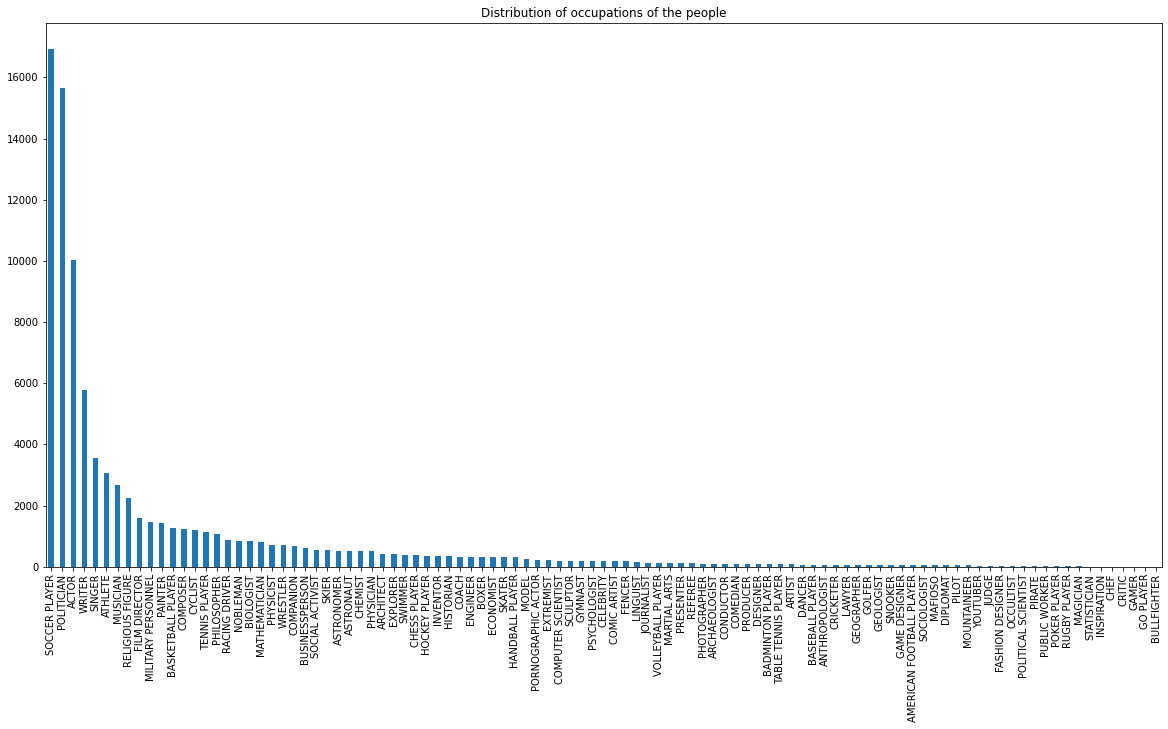

In [ ]:
persons['occupation'].value_counts().plot(kind='bar', figsize=(20,10), title="Distribution of occupations of the people")

In [ ]:
pantheon_df=persons.drop(['prob_ratio', 'gender', 'twitter', 'alive', 'l', 'hpi_raw', 'bplace_name', 'bplace_lat', 'bplace_lon', 'bplace_geonameid', 'bplace_country', 'birthdate', 'birthyear', 'dplace_name', 'dplace_lat', 'dplace_lon', 'dplace_geonameid', 'dplace_country', 'deathdate', 'deathyear', 'bplace_geacron_name', 'dplace_geacron_name', 'is_group', 'l_', 'age', 'non_en_page_views', 'coefficient_of_variation'], axis=1)

In [ ]:
pantheon_df.head()

# Loading big data files

### Load the data for each years with a chunksize because the data is too big to fit in the RAM

In [ ]:
df_2015 = pd.read_json("/content/drive/MyDrive/Quotebank/quotes-2015.json-004.bz2", compression="bz2", chunksize=1000000, lines=True, encoding='UTF-8')
df_2016 = pd.read_json("/content/drive/MyDrive/Quotebank/quotes-2016.json-002.bz2", compression="bz2", chunksize=1000000, lines=True, encoding='UTF-8')
df_2017 = pd.read_json("/content/drive/MyDrive/Quotebank/quotes-2017.json-005.bz2", compression="bz2", chunksize=1000000, lines=True, encoding='UTF-8')
df_2018 = pd.read_json("/content/drive/MyDrive/Quotebank/quotes-2018.json-006.bz2", compression="bz2", chunksize=1000000, lines=True, encoding='UTF-8')
df_2019 = pd.read_json("/content/drive/MyDrive/Quotebank/quotes-2019.json-003.bz2", compression="bz2", chunksize=1000000, lines=True, encoding='UTF-8')

### Get the most popular speakers
We get the most popular speaker by suming the number of occurrences quotations for each speaker and then sort them in descending order. Indeed if a speaker is more often cited, it means that he is more popular.  
Here we use only a sample of the data (the first batch) !

In [ ]:
#a.groupby(a['speaker']).quotation.count().sort_values(ascending=False).head(10)
top15_popular_2015 = next(df_2015).groupby('speaker').numOccurrences.sum().sort_values(ascending=False).head(15)
top15_popular_2016 = next(df_2016).groupby('speaker').numOccurrences.sum().sort_values(ascending=False).head(15)
top15_popular_2017 = next(df_2017).groupby('speaker').numOccurrences.sum().sort_values(ascending=False).head(15)
top15_popular_2018 = next(df_2018).groupby('speaker').numOccurrences.sum().sort_values(ascending=False).head(15)
top15_popular_2019 = next(df_2019).groupby('speaker').numOccurrences.sum().sort_values(ascending=False).head(15)

### Top 15 most popular speakers for each years

In [ ]:
print(top15_popular_2015)
print(top15_popular_2016)
print(top15_popular_2017)
print(top15_popular_2018)
print(top15_popular_2019)

In [ ]:
donald_trump_pop_2015 = top15_popular_2015[top15_popular_2015.index == 'Donald Trump'].values
donald_trump_pop_2016 = top15_popular_2016[top15_popular_2016.index == 'Donald Trump'].values
donald_trump_pop_2017 = top15_popular_2017[top15_popular_2017.index == 'President Donald Trump'].values
donald_trump_pop_2018 = top15_popular_2018[top15_popular_2018.index == 'President Donald Trump'].values
donald_trump_pop_2019 = top15_popular_2019[top15_popular_2019.index == 'President Donald Trump'].values

donald_trump_pop_years = []
donald_trump_pop_years.append(donald_trump_pop_2015.item())
donald_trump_pop_years.append(donald_trump_pop_2016.item())
donald_trump_pop_years.append(donald_trump_pop_2017.item())
donald_trump_pop_years.append(donald_trump_pop_2018.item())
donald_trump_pop_years.append(donald_trump_pop_2019.item())
donald_trump_pop_years

years = [2015, 2016, 2017, 2018, 2019]

## Donald Trump popularity from 2015 to 2019

In [ ]:
fig, ax = plt.subplots()
ax.plot(years, donald_trump_pop_years)
ax.set(xlabel='Years', ylabel='Popularity', title='Trump popularity')
plt.show()

### Example of how we can apply the most popular speaker on all the data and not only on a batch

In [ ]:
chunk_list = []
for batch in df:
    more_popular = batch.groupby(batch['speaker']).numOccurrences.sum().sort_values(ascending=False).head(15)
    chunk_list.append(more_popular)
df_concat = pd.concat(chunk_list)
df_concat.groupby(['speaker']).sum().sort_values(ascending=False)
wikidata = pd.read_csv('DATA/wikidata_labels_descriptions.csv.bz2', compression='bz2', index_col='QID', chunksize=1000000)

### Get the QIDs associated to Donald Trump from wikidata

In [ ]:
QID_trump_list = []
for batch in wikidata:
    QID_trump = batch[(batch.index == 'Q22686') | (batch.index == 'Q27947481')]
    if len(QID_trump.values) != 0:
        QID_trump_list.append(QID_trump)
QID_trump_list

In [ ]:
batch_2015 = next(df_2015)
QIDs_Trump = batch_2015[batch_2015['speaker'] == 'Donald Trump']['qids'].head(1).values.item()
QIDs_Trump

In [ ]:
presidents = batch_2015[batch_2015['speaker'].str.contains('President')]
presidents['speaker'].unique()

# Memory Tests and Extra Stuff

In [ ]:
# # https://pandas.pydata.org/pandas-docs/stable/user_guide/scale.html
# # use dask?pyspark?

# ts.memory_usage(deep=True)
# ts2 = ts.copy()
# ts2["name"] = ts2["name"].astype("category")
# ts2.memory_usage(deep=True)
# ts2["id"] = pd.to_numeric(ts2["id"], downcast="unsigned")
# ts2[["x", "y"]] = ts2[["x", "y"]].apply(pd.to_numeric, downcast="float")

In [ ]:
path_to_file = '/content/drive/MyDrive/Quotebank/quotes-2020.json.bz2' 
# # path_to_out = '/content/quotes-2020-domains.json.bz2'
c=0

big_data = []
# max_v=500000
with bz2.open(path_to_file, 'rb') as s_file:
    # with bz2.open(path_to_out, 'wb') as d_file:
        for instance in s_file:
            c+=1
            instance = json.loads(instance) # loading a sample
            df = pd.json_normalize(instance)
            df = df.drop(['probas','urls','phase'], axis=1)
            big_data.append(df)
            # print(instance)
            if c%100000==0:
              print(c)
          

big_data = pd.concat(big_data)
# quotes = appended_data.drop(['speaker','qids','date','numOccurrences','probas','urls','phase'], axis=1)
big_data.describe()

# out='/content/drive/MyDrive/ADA/quotes_2020.csv'
# big_data.to_csv(out,index=False)

In [ ]:
quotes_all = ps.read_json("/content/drive/MyDrive/Quotebank/quotes-2020.json.bz2")
quotes_all.shape
quotes_all.columns
quotes_all.head()

In [ ]:
speaker_attribs = pd.read_parquet('/content/drive/MyDrive/ADA/speaker_attributes.parquet')
speaker_attribs.shape
speaker_attribs.columns
speaker_attribs_d = speaker_attribs.drop(['aliases', 'date_of_birth', 'lastrevid', 'type', 'ethnic_group', 'US_congress_bio_ID', 'party',
       'academic_degree','candidacy', 'religion'], axis=1)
speaker_attribs_d.shape
speaker_attribs_d.notnull().sum()/len(speaker_attribs_d)

In [ ]:
df_speakers = speaker_attribs_d.sample(100000)
df_speakers.head()

nationality  ...                    religion
0  [Q161885, Q30]  ...                   [Q682443]
1          [Q145]  ...                        None
2           [Q31]  ...                        None
3           [Q30]  ...  [Q329646, Q682443, Q33203]
4           [Q29]  ...                        None

[5 rows x 11 columns]